<img height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px">

<h1>2019 Deep Learning _ Final Project</h1>

MultipleGPU using AlexNet

- Myeong-Ha Hwang

### AlexNet

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchsummary import summary
from tqdm import tqdm
import torch.nn.functional as F

In [0]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 100
NUM_EPOCH = 50
LEARNING_RATE = 0.01
CRITERION = nn.CrossEntropyLoss()

In [3]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [0]:
def fit(model,train_loader):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [0]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

In [0]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        
        #self.avgpool = nn.AdaptiveAvgPool2d((8,8))
        self.avgpool = nn.AvgPool2d(8)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128,128),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(128,128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
AlexNet_model = AlexNet().cuda()
train_loss0 = []
test_accuracy0 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss0.append(fit(AlexNet_model, train_loader))
    test_accuracy0.append(eval(AlexNet_model, test_loader))

100%|██████████| 50/50 [06:55<00:00,  8.31s/it]


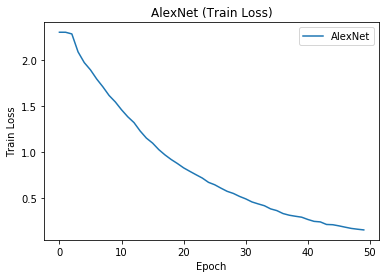

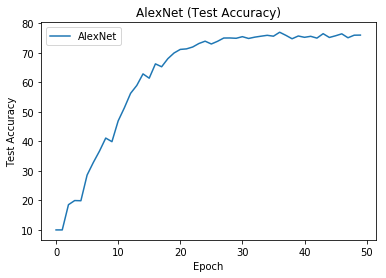

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_loss0, label='AlexNet')
#plt.plot(train_loss4, label='ResNet')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('AlexNet (Train Loss)')
plt.show()

plt.plot(test_accuracy0, label='AlexNet')
#plt.plot(test_accuracy4, label='ResNet')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('AlexNet (Test Accuracy)')
plt.show()

### CNN

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 8, 5),
                                    nn.ReLU(True),
                                    nn.Conv2d(8, 8, 5),
                                    nn.ReLU(True),
                                    nn.MaxPool2d(2,2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(8, 16, 5),
                                    nn.ReLU(True),
                                    nn.Conv2d(16, 16, 5),
                                    nn.ReLU(True),
                                    nn.MaxPool2d(2,2))
        
        self.fc = nn.Linear(16*2*2, 10)
       
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=x.view(x.size(0), -1)
        x=self.fc(x)
        return x

In [10]:
cnn_model = SimpleCNN().cuda()
train_loss2 = []
test_accuracy2 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss2.append(fit(cnn_model, train_loader))
    test_accuracy2.append(eval(cnn_model, test_loader))
summary(cnn_model, input_size = (3,32,32))

100%|██████████| 50/50 [05:41<00:00,  6.84s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             608
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 24, 24]           1,608
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6             [-1, 16, 8, 8]           3,216
              ReLU-7             [-1, 16, 8, 8]               0
            Conv2d-8             [-1, 16, 4, 4]           6,416
              ReLU-9             [-1, 16, 4, 4]               0
        MaxPool2d-10             [-1, 16, 2, 2]               0
           Linear-11                   [-1, 10]             650
Total params: 12,498
Trainable params: 12,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

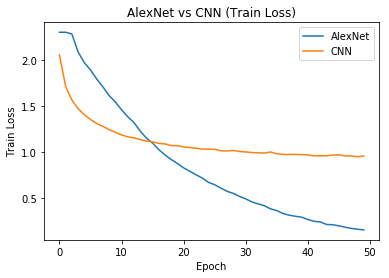

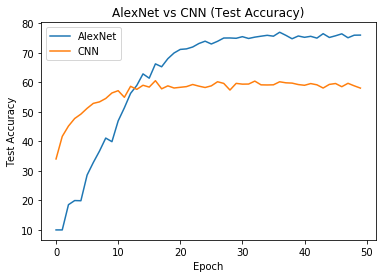

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_loss0, label='AlexNet')
plt.plot(train_loss2, label='CNN')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('AlexNet vs CNN (Train Loss)')
plt.show()

plt.plot(test_accuracy0, label='AlexNet')
plt.plot(test_accuracy2, label='CNN')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('AlexNet vs CNN (Test Accuracy)')
plt.show()